In [1]:
import torch
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import cv2
from skimage.feature import hog

In [2]:
transform = transforms.Compose([transforms.ToTensor()])
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X = mnist_dataset.data.numpy()
y = mnist_dataset.targets.numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


100.0%
100.0%
100.0%
100.0%


Epoch 1, Loss: 2.407241106033325, Accuracy: 0.36875
Epoch 2, Loss: 1.9772640466690063, Accuracy: 0.5438333333333333
Epoch 3, Loss: 1.7627382278442383, Accuracy: 0.63275
Epoch 4, Loss: 1.607157588005066, Accuracy: 0.6965833333333333
Epoch 5, Loss: 1.4783467054367065, Accuracy: 0.7358333333333333
Epoch 6, Loss: 1.3654519319534302, Accuracy: 0.7585833333333334
Epoch 7, Loss: 1.2666537761688232, Accuracy: 0.78375
Epoch 8, Loss: 1.177912950515747, Accuracy: 0.8050833333333334
Epoch 9, Loss: 1.0950133800506592, Accuracy: 0.8183333333333334
Epoch 10, Loss: 1.0232113599777222, Accuracy: 0.8325833333333333
Epoch 11, Loss: 0.954501211643219, Accuracy: 0.8425833333333334
Epoch 12, Loss: 0.8948524594306946, Accuracy: 0.8556666666666667
Epoch 13, Loss: 0.8377918004989624, Accuracy: 0.8594166666666667
Epoch 14, Loss: 0.7868286371231079, Accuracy: 0.8693333333333333
Epoch 15, Loss: 0.7383833527565002, Accuracy: 0.8755
Epoch 16, Loss: 0.6944282054901123, Accuracy: 0.8793333333333333
Epoch 17, Loss: 0.

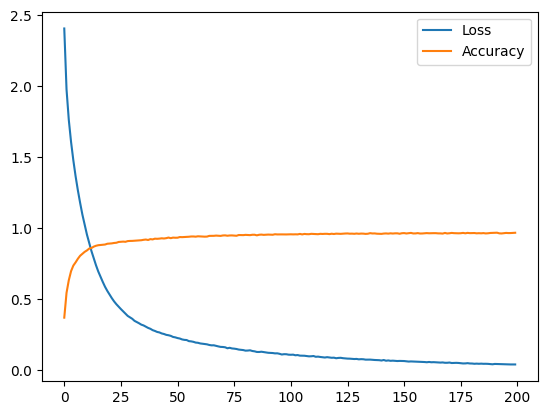

In [3]:

class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, 256)
        self.bn1 = torch.nn.BatchNorm1d(256)
        self.dropout1 = torch.nn.Dropout(0.5)
        self.fc2 = torch.nn.Linear(256, 128)
        self.bn2 = torch.nn.BatchNorm1d(128)
        self.dropout2 = torch.nn.Dropout(0.5)
        self.fc3 = torch.nn.Linear(128, 64)
        self.bn3 = torch.nn.BatchNorm1d(64)
        self.fc4 = torch.nn.Linear(64, 10)

    def forward(self, x):
        x = x.view(-1, 28 * 28) 
        x = torch.relu(self.bn1(self.fc1(x)))
        x = self.dropout1(x)
        x = torch.relu(self.bn2(self.fc2(x)))
        x = self.dropout2(x)
        x = torch.relu(self.bn3(self.fc3(x)))
        x = self.fc4(x)
        return x

model = MLP()
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-5)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32) / 255.0  # Нормализация
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32) / 255.0  # Нормализация
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

losses = []
accuracies = []
for epoch in range(200):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    with torch.no_grad():
        predictions = model(X_test_tensor)
        predicted_labels = torch.argmax(predictions, dim=1)
        accuracy = accuracy_score(y_test, predicted_labels.numpy())
        accuracies.append(accuracy)

    print(f"Epoch {epoch+1}, Loss: {loss.item()}, Accuracy: {accuracy}")

plt.plot(losses, label='Loss')
plt.plot(accuracies, label='Accuracy')
plt.legend()
plt.show()

In [4]:
with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_labels = torch.argmax(predictions, dim=1)

accuracy_mlp = accuracy_score(y_test, predicted_labels.numpy())
recall_mlp = recall_score(y_test, predicted_labels.numpy(), average='macro')
f1_mlp = f1_score(y_test, predicted_labels.numpy(), average='macro')
conf_matrix_mlp = confusion_matrix(y_test, predicted_labels.numpy())

print(f"MLP Accuracy: {accuracy_mlp}")
print(f"MLP Recall: {recall_mlp}")
print(f"MLP F1-Score: {f1_mlp}")
print("Confusion Matrix (MLP):")
print(conf_matrix_mlp)

MLP Accuracy: 0.9638333333333333
MLP Recall: 0.963589872085065
MLP F1-Score: 0.9635601884041536
Confusion Matrix (MLP):
[[1158    0    3    2    2    3    2    0    4    1]
 [   0 1298    9    5    2    1    0    3    4    0]
 [   0    9 1132    5    5    1    3    7    9    3]
 [   1    2   21 1159    1   14    0    6    7    8]
 [   3    3    2    0 1144    1    5    3    2   13]
 [   5    4    7   12    4 1049    6    2    9    6]
 [   5    1    3    0    3   10 1150    0    5    0]
 [   1    7    9    4    4    3    2 1251    4   14]
 [   6    6    3    9    6   13    2    4 1098   13]
 [   6    0    1    5   22    6    1   17    9 1127]]


In [5]:
import torch
import torch.nn as nn

model.eval()
dummy_input = torch.randn(1, 1, 28, 28)
dummy_input = dummy_input.view(-1, 28 * 28)
print(dummy_input.size())

torch.onnx.export(
    model,
    dummy_input,
    "model.onnx",
    export_params=True,
    opset_version=13,
    #   do_constant_folding=True,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
)

print("Модель успешно экспортирована в формат ONNX!")

torch.Size([1, 784])
Модель успешно экспортирована в формат ONNX!


In [6]:
import onnx
from onnxruntime.quantization import quantize_dynamic, QuantType

onnx_model_path = "model.onnx"
quantized_onnx_model_path = "model_quantized.onnx"

# Выполнение динамического квантования
quantize_dynamic(
    onnx_model_path,
    quantized_onnx_model_path,
    weight_type=QuantType.QUInt8
)

In [7]:
import os

original_size = os.path.getsize(onnx_model_path)
quantized_size = os.path.getsize(quantized_onnx_model_path)

print(f"Размер исходной модели: {original_size / 1024:.2f} KB")
print(f"Размер квантованной модели: {quantized_size / 1024:.2f} KB")
print(f"Экономия размера: {(original_size - quantized_size) / 1024:.2f} KB")

Размер исходной модели: 957.28 KB
Размер квантованной модели: 251.27 KB
Экономия размера: 706.00 KB


In [9]:
import onnxruntime
with torch.no_grad():
    pytorch_output = model(dummy_input)
    print(pytorch_output)

ort_session = onnxruntime.InferenceSession("model_quantized.onnx")
onnx_input = dummy_input.numpy().astype(np.float32)  
onnx_output = ort_session.run(None, {ort_session.get_inputs()[0].name: onnx_input})
print(onnx_output)

tensor([[-0.1828, -2.5073, -0.4620, -3.5076, -0.5384, -5.1296, -4.6969,  5.7547,
         -4.9357, -4.9288]])
[array([[-0.25448143, -2.5038464 , -0.42026192, -3.4777303 , -0.5553022 ,
        -5.121178  , -4.692543  ,  5.774374  , -4.916712  , -4.937663  ]],
      dtype=float32)]


In [ ]:
import onnx
from onnxruntime.transformers.optimizer import optimize_model

optimized_model = optimize_model("model.onnx",  opt_level=1)
print(type(optimized_model))
optimized_model.save_model_to_file("model_optimized.onnx")

<class 'onnx_model_bert.BertOnnxModel'>
